#7 - Notebook that implements a Random Forest Model using TF-IDF

---

### **This notebook primarily contains code that implements a Random Forest model using TF-IDF (an NLP technique) and the dataset that was created in the 4th notebook.**
---

tf-idf stands for term frequency-inverse document frequency. This model essentially works by using a weighting scheme that assigns each term in a document a weight based on its term frequency (tf) and inverse document frequency (idf). The terms with higher weight scores are considered to be more important.

**(1) term-frequency:**

*Term-frequency indicates the number of occurrences of a particular term t in document d.*

```
tf(t, d) = N(t, d)

wherein,

tf(t, d) = term frequency for a term t in document d.

N(t, d)  = number of times a term t occurs in document d.
```

**(2) inverse document frequency:**

*Inverse document frequency typically measures how important a term is.*

```
idf(t) = N/df(t) 

where,

df(t) = Document frequency of a term t
```


**Example:**

**TF:** When a 100-word document contains the term “cat” 12 times, the TF for the word ‘cat’ is 12/100 = 0.12.

**IDF:** Let’s say the size of the corpus is 10,000,000 million documents. If we assume there are 0.3 million documents that contain the term “cat”, then the IDF is given by log (10,000,000/300,000) = 1.52.

**TF-IDF:** Then, we put the TF and IDF calculations together to get a TF-IDF score. Hence, 

**(TF-IDF)cat** is given by 0.12 x 1.52 = 0.182

A TF-IDF score of 0.182 is much closer to 0 than 1. This suggests that “cat” is a common term with less weight. 

---

The random forest is a classification algorithm consisting of many decisions trees. It uses the results from TF-IDF and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.


---
# Importing libraries and defining constants

In [1]:
# Imports library necessary for mounting Google Drive.
from google.colab import drive
# Mounts Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copies the model helper function python program from Google Drive to Colab Storage for use in this notebook.
!cp "drive/MyDrive/Fake News Classifier/Helper Functions/model_helperfunctions.py" .

In [3]:
# Imports all the libraries required for the notebook to run.
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import model_helperfunctions
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [4]:
# Sets the path for the data directory and the filenames.
DATA_PATH = "/content/drive/MyDrive/Data/"
PRE_PROCESSED_DATA_FILE_NAME = 'kaggle_newsdataset_preprocessed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [5]:
# Sets the path to save the models as well as the filenames.
SAVE_MODEL = True
MODEL_PATH = "/content/drive/MyDrive/Models/"
MODEL_FILE_NAME = 'rf_tf-idf_model.sav'

# Load the data

In [6]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [7]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [8]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


# Split the data

In [9]:
y = df.label
X = df.drop('label', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [11]:
X_train.shape

(30910, 4)

In [12]:
X_test.shape

(7728, 4)

# Encode the labels

In [13]:
le = LabelEncoder()

In [14]:
y_train_enc = le.fit_transform(y_train)

In [15]:
y_test_enc = le.transform(y_test)

# Train the models

In [16]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
  
    #Train and evaluate a bag of words representation with a random forest classifier.
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helperfunctions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helperfunctions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## title & text only - lowercase, only stopwords but a larger set.

In [17]:
# Using the expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

Remove 'via' from the list of stopwords as it is particular to this dataset.

In [18]:
expanded_stopwords.remove('via')

In [19]:
def lowercase_and_only_expanded_stopwords(doc):
    # Remove stopwords and lowercase tokens.
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

In [20]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

Classification report for Training set
              precision    recall  f1-score   support

        fake       0.97      0.97      0.97     13957
        true       0.97      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


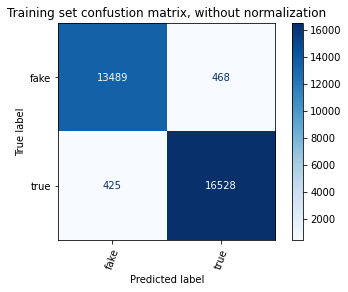

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


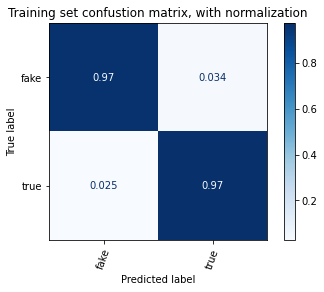

Classification report for Test set
              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      3490
        true       0.94      0.96      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.94      0.94      7728
weighted avg       0.95      0.95      0.95      7728



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


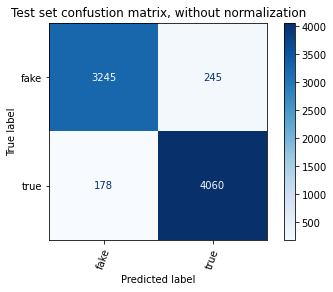

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


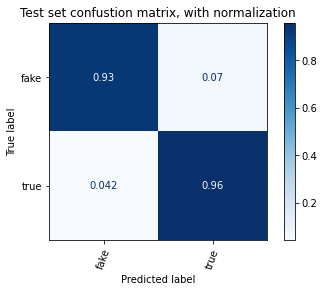

In [21]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helperfunctions.passthrough,
                                                 min_samples_split = 0.005)

In [22]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,importance
said,0.183842
on,0.062323
you,0.045779
just,0.041490
this,0.031545
here,0.030864
in,0.025543
is,0.024555
like,0.021553
its,0.019124


# Saving the model

In [23]:
try: 
    os.mkdir(MODEL_PATH)
    print('Directory to save the models has been created.')
except FileExistsError:
    print('Directory to save the models already exists. No new directory will be created')
    pass

Directory to save the models already exists. No new directory will be created


In [24]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))

---
# **Summary**

Using TF-IDF as features rather than word vectors (bag of words) increased the accuracy and f1 scores by a little bit.  This model is the best so far, both as far as its metrics and its ability to generalize. 

It helps differentiate stories by reducing the importance of some of the most common stopwords.  Surprisingly, the top 5 features didn't change, but the order changed and some different words made it into the top 30.